In [204]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import np as np

In [175]:
X_AXIS = 0
Y_AXIS = 1
NORMAL_ARROWS_SCALING_FACTOR = 100

In [67]:
airfoil_nodes = np.loadtxt("naca634421.dat", skiprows=1)

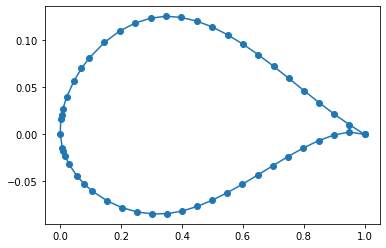

In [68]:
# Plot nodes and single line to represent the airfoil
plt.figure()
plt.scatter(airfoil_nodes.T[X_AXIS], airfoil_nodes.T[Y_AXIS])
plt.plot(airfoil_nodes.T[X_AXIS], airfoil_nodes.T[Y_AXIS])
plt.show()

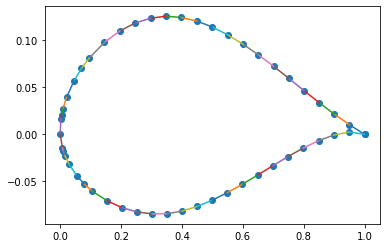

In [69]:
# Plot nodes and individual lines to represent each panel
plt.figure()
plt.scatter(airfoil_nodes.T[X_AXIS], airfoil_nodes.T[Y_AXIS])
for i in range(len(airfoil_nodes) - 1):
    plt.plot(airfoil_nodes.T[X_AXIS][i:i+2], airfoil_nodes.T[Y_AXIS][i:i+2])
plt.show()

In [70]:
# Downsample the number of nodes defining the airfoil
downsampling_ratio = 2
airfoil_nodes_downsampled = airfoil_nodes[:-1][::downsampling_ratio]
if not (airfoil_nodes_downsampled[0] == airfoil_nodes_downsampled[-1]).all():
    airfoil_nodes_downsampled = np.vstack((airfoil_nodes_downsampled, airfoil_nodes_downsampled[0]))

In [80]:
# Get center nodes for each panel
airfoil_panels_centres = np.array([])
for i in range(len(airfoil_nodes) - 1):
    x_centre = (airfoil_nodes.T[X_AXIS][i+1] + airfoil_nodes.T[X_AXIS][i]) / 2
    y_centre = (airfoil_nodes.T[Y_AXIS][i+1] + airfoil_nodes.T[Y_AXIS][i]) / 2
    airfoil_panels_centres = np.r_[airfoil_panels_centres, [x_centre, y_centre]]
airfoil_panels_centres = airfoil_panels_centres.reshape(-1, 2)


In [191]:
# Get normal vector for each panel
airfoil_panels_normals = np.array([])
for i in range(len(airfoil_nodes) - 1):
    if airfoil_nodes.T[Y_AXIS][i] > 0:
        m1 = (airfoil_nodes.T[Y_AXIS][i+1] - airfoil_nodes.T[Y_AXIS][i]) / (airfoil_nodes.T[X_AXIS][i+1] - airfoil_nodes.T[X_AXIS][i])
    else:
        m1 = (airfoil_nodes.T[Y_AXIS][i] - airfoil_nodes.T[Y_AXIS][i+1]) / (airfoil_nodes.T[X_AXIS][i+1] - airfoil_nodes.T[X_AXIS][i])
    m2 = -1 / m1
    length = np.sqrt(m1**2 + m2**2)
    m1 /= length
    m2 /= length
    airfoil_panels_normals = np.r_[airfoil_panels_normals, [m1, m2]]
airfoil_panels_normals = airfoil_panels_normals.reshape(-1, 2)


In [205]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.

        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.

        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point

        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length

        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)

        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface

        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [221]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.

    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.

    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """

    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center

    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle

    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points

    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])

    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]

    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

    return panels

In [223]:
# discretize geoemetry into panels
panels = define_panels(airfoil_points.T[0], airfoil_points.T[1], N=40)

In [268]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).

        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees to radians

# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=12.0)

In [269]:
from scipy import integrate, linalg

def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.

    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.

    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [270]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.

    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.

    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [271]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.

    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.

    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [272]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [273]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.

    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.

    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [274]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.

    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.

    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [275]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system
    arising from the freestream contribution.

    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.

    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

In [276]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [277]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]

# store circulation density
gamma = strengths[-1]

In [278]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.

    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                      for panel in panels])

    strengths = np.append([panel.sigma for panel in panels], gamma)

    tangential_velocities = np.dot(A, strengths) + b

    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [279]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [280]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.

    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [281]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

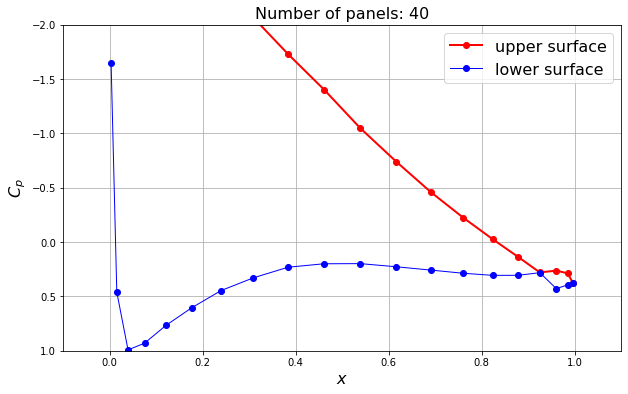

In [282]:
# plot surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -2.0)
plt.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [283]:
# calculate the accuracy
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.001422


In [284]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 1.847


In [285]:
import math

def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v

In [290]:
# define a mesh grid
nx, ny = 100, 100  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

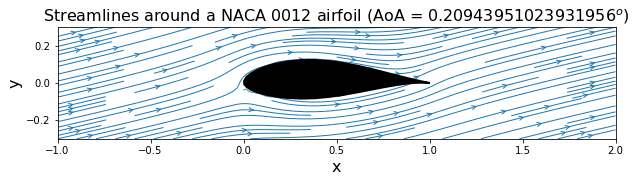

In [291]:
# plot the velocity field
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(freestream.alpha),
             fontsize=16);

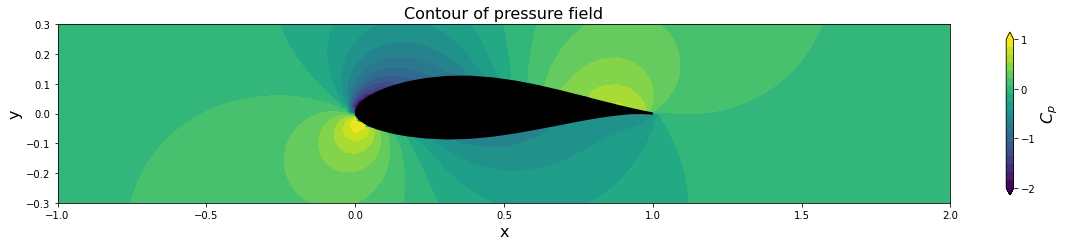

In [309]:
# compute the pressure field
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

# plot the pressure field
width = 20
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X, Y, cp,
                        levels=np.linspace(-2.0, 1.0, 20), extend='both')
cbar = plt.colorbar(contf,
                       orientation='vertical',
                       shrink=0.15, pad = 0.05,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Contour of pressure field', fontsize=16);

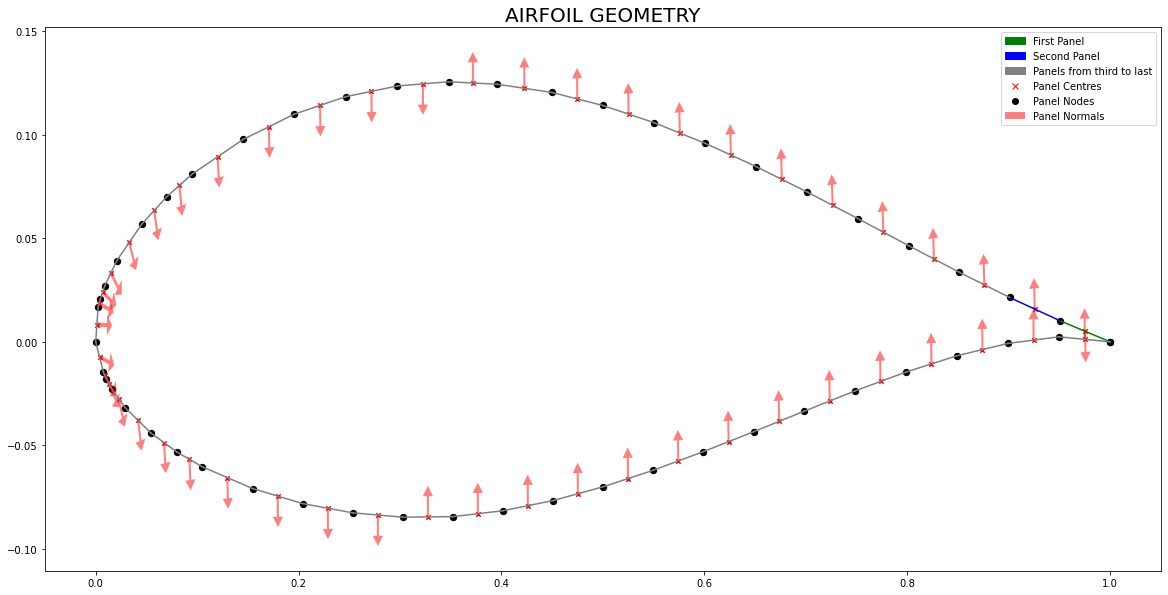

In [201]:
# Plot panels centres and normals, together with previous visuals
plt.figure(figsize=(20, 10))
plt.title("AIRFOIL GEOMETRY", fontsize=20)
plt.scatter(airfoil_nodes.T[X_AXIS], airfoil_nodes.T[Y_AXIS], s=40, c="black")
for i in range(len(airfoil_nodes) - 1):
    if i == 0:
        colour = "green"
    elif i == 1:
        colour = "blue"
    else:
        colour = "grey"
    plt.plot(airfoil_nodes.T[X_AXIS][i:i+2], airfoil_nodes.T[Y_AXIS][i:i+2], c=colour, label="TEST")
plt.scatter(airfoil_panels_centres.T[X_AXIS], airfoil_panels_centres.T[Y_AXIS], marker="x", c="r", s=20)

for i in range(len(airfoil_panels_normals)):
    arrow = plt.arrow(
        x=airfoil_panels_centres.T[X_AXIS][i],
        y=airfoil_panels_centres.T[Y_AXIS][i],
        dx=airfoil_panels_normals.T[X_AXIS][i] / NORMAL_ARROWS_SCALING_FACTOR,
        dy=airfoil_panels_normals.T[Y_AXIS][i] / NORMAL_ARROWS_SCALING_FACTOR,
        width=0.002,
        facecolor='red',
        edgecolor='None',
        head_width=0.01,
        head_length=0.005,
        alpha=0.5,
        label="Panel Normals"
    )

first_panel = mpatches.Patch(color='green', label='First Panel')
second_panel = mpatches.Patch(color='blue', label='Second Panel')
remaining_panels = mpatches.Patch(color='grey', label='Panels from third to last')
panel_centres = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Panel Centres')
panel_nodes = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Panel Nodes')
plt.legend(handles=[first_panel, second_panel, remaining_panels, panel_centres, panel_nodes, arrow])

plt.show()